CARGA Y LIMPIEZA PARA EL MODELO

---



In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import pandas as pd
file_path = "/content/drive/MyDrive/Dataset Idealista/pisosBarcelona-21-04-2025-clean.csv"
df = pd.read_csv(file_path, encoding='latin1')
print("Datos cargados exitosamente.")
print(f"Dimensiones iniciales: {df.shape}")
print("-" * 30)

Datos cargados exitosamente.
Dimensiones iniciales: (8478, 37)
------------------------------


In [71]:
# BLOQUE 1: Importar Librerías y Cargar Datos (Sin Cambios)
print("--- BLOQUE 1: Importar Librerías y Cargar Datos ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic # Para calcular distancias
from sklearn.model_selection import train_test_split
# Cambiamos el modelo a importar
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# Importamos KMeans para clustering
from sklearn.cluster import KMeans

# Instalar geopy y xgboost si no están instalados (ejecutar en celdas separadas si es necesario)
!pip install geopy
!pip install xgboost

--- BLOQUE 1: Importar Librerías y Cargar Datos ---


In [72]:
# BLOQUE 2: Limpieza de la Columna 'floor' (Sin Cambios)
print("--- BLOQUE 2: Limpieza de la columna 'floor' ---")
floor_mapping = { 'bj': 0.0, 'en': 0.5, 'ss': -1.0 }
df['floor'] = df['floor'].replace(floor_mapping)
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
median_floor = df['floor'].median()
print(f"Mediana calculada para 'floor': {median_floor}")
df['floor'].fillna(median_floor, inplace=True)
print("'floor' limpiado e imputado.")
print(f"Valores nulos restantes en 'floor': {df['floor'].isnull().sum()}")
print("-" * 30)

--- BLOQUE 2: Limpieza de la columna 'floor' ---
Mediana calculada para 'floor': 2.0
'floor' limpiado e imputado.
Valores nulos restantes en 'floor': 0
------------------------------


<ipython-input-72-66b8e354b873>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['floor'].fillna(median_floor, inplace=True)


In [73]:
# BLOQUE 3: Limpieza de la Columna 'exterior' (Sin Cambios)
print("--- BLOQUE 3: Limpieza de la columna 'exterior' ---")
df['exterior'] = df['exterior'].replace({'Unknown': np.nan, True: 1, False: 0})
df['exterior'] = pd.to_numeric(df['exterior'], errors='coerce')
mode_exterior = df['exterior'].mode()[0]
print(f"Moda calculada para 'exterior': {mode_exterior}")
df['exterior'].fillna(mode_exterior, inplace=True)
df['exterior'] = df['exterior'].astype(int)
print("'exterior' limpiado e imputado.")
print(f"Valores nulos restantes en 'exterior': {df['exterior'].isnull().sum()}")
print("-" * 30)

--- BLOQUE 3: Limpieza de la columna 'exterior' ---
Moda calculada para 'exterior': 1.0
'exterior' limpiado e imputado.
Valores nulos restantes en 'exterior': 0
------------------------------


<ipython-input-73-c7571db5a37e>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['exterior'] = df['exterior'].replace({'Unknown': np.nan, True: 1, False: 0})
<ipython-input-73-c7571db5a37e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['exterior'].fillna(mode_exterior, inplace=True)


In [74]:
# BLOQUE 4: Unificar Variables de Parking (Sin Cambios)
print("--- BLOQUE 4: Unificar Variables de Parking ---")
conditions = [
    (df['hasParking'] == 1) & (df['isParkingIncludedInPrice'] == 1),
    (df['hasParking'] == 1) & (df['isParkingIncludedInPrice'] == 0),
    (df['hasParking'] == 0) ]
choices = ['Included', 'Optional/Not Included', 'None']
df['parking_status'] = np.select(conditions, choices, default='Unknown')
df.drop(['hasParking', 'isParkingIncludedInPrice'], axis=1, inplace=True)
print("Columna 'parking_status' creada y originales eliminadas.")
print("-" * 30)

--- BLOQUE 4: Unificar Variables de Parking ---
Columna 'parking_status' creada y originales eliminadas.
------------------------------


In [75]:
# BLOQUE 5: Seleccionar Columnas Relevantes Iniciales + Crear Copia (Sin Cambios)
print("--- BLOQUE 5: Seleccionar Columnas Relevantes Iniciales + Crear Copia ---")
relevant_columns = [
    'price', 'size', 'rooms', 'bathrooms', 'floor', 'hasLift', 'exterior',
    'propertyType', 'status', 'parking_status', 'latitude', 'longitude' ]
df_model = df[relevant_columns].copy()
print(f"DataFrame 'df_model' creado con {df_model.shape[1]} columnas relevantes.")
print("-" * 30)

--- BLOQUE 5: Seleccionar Columnas Relevantes Iniciales + Crear Copia ---
DataFrame 'df_model' creado con 12 columnas relevantes.
------------------------------


In [76]:
# BLOQUE 6: Feature Engineering - Distancias a POIs (Sin Cambios)
print("--- BLOQUE 6: Feature Engineering - Distancias a POIs ---")
df_model['latitude'] = pd.to_numeric(df_model['latitude'], errors='coerce')
df_model['longitude'] = pd.to_numeric(df_model['longitude'], errors='coerce')
rows_before = df_model.shape[0]
df_model.dropna(subset=['latitude', 'longitude'], inplace=True)
rows_after = df_model.shape[0]
if rows_before != rows_after:
    print(f"Advertencia: Se eliminaron {rows_before - rows_after} filas por NaN en lat/lon.")
df_model['coords'] = list(zip(df_model['latitude'], df_model['longitude']))
pois = {
    'placa_catalunya': (41.3874, 2.1700), 'barceloneta_beach': (41.3790, 2.1885),
    'sants_estacio': (41.3793, 2.1400), 'camp_nou': (41.3809, 2.1228),
    'parc_guell': (41.4145, 2.1527) }
print("Calculando distancias a POIs...")
for name, poi_coords in pois.items():
    col_name = f'dist_km_{name}'
    try:
        df_model[col_name] = df_model['coords'].apply(lambda x: geodesic(x, poi_coords).km if pd.notnull(x[0]) and pd.notnull(x[1]) else np.nan)
    except Exception as e:
        print(f"Error calculando distancia a {name}: {e}. Columna {col_name} no creada.")
df_model.drop('coords', axis=1, inplace=True)
print("Distancias a POIs calculadas.")
print("-" * 30)

--- BLOQUE 6: Feature Engineering - Distancias a POIs ---
Calculando distancias a POIs...
Distancias a POIs calculadas.
------------------------------


In [77]:
# --- BLOQUE MODIFICADO ---
# BLOQUE 7: Feature Engineering - Clustering Geográfico (con k ajustable)
print("--- BLOQUE 7: Feature Engineering - Clustering Geográfico ---")

# --- AJUSTA ESTE VALOR ---
# Prueba diferentes números de clusters (ej: 20, 30, 40, 50) y re-ejecuta desde aquí
k_clusters = 40  # <---- Cambia este número para probar diferentes K
# --- FIN AJUSTE ---

# Seleccionar coordenadas para clustering
coords_for_clustering = df_model[['latitude', 'longitude']].copy()

# Escalar coordenadas ANTES de clustering
scaler_geo = StandardScaler()
coords_scaled = scaler_geo.fit_transform(coords_for_clustering)

# Definir y ajustar KMeans
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
print(f"Ajustando KMeans con k={k_clusters} clusters...")
kmeans.fit(coords_scaled)

# Añadir la etiqueta del cluster al dataframe principal
df_model['geo_cluster'] = kmeans.labels_
# Convertir a string para que sea tratado como categórico
df_model['geo_cluster'] = df_model['geo_cluster'].astype(str)

print(f"Columna 'geo_cluster' creada con {k_clusters} clusters.")
print("-" * 30)

# NOTA: Después de cambiar 'k_clusters', debes re-ejecutar todos los bloques
# desde este (Bloque 7) hasta el final para ver el impacto en los resultados.

--- BLOQUE 7: Feature Engineering - Clustering Geográfico ---
Ajustando KMeans con k=40 clusters...
Columna 'geo_cluster' creada con 40 clusters.
------------------------------


In [78]:
# BLOQUE 8: Feature Engineering - Interacciones (Size x Location - Sin Cambios)
print("--- BLOQUE 8: Feature Engineering - Interacciones (Size x Location) ---")
epsilon = 0.1
required_cols_interact = ['size', 'dist_km_placa_catalunya', 'latitude']
if all(col in df_model.columns for col in required_cols_interact):
    df_model['size_x_inv_dist_catalunya'] = df_model['size'] / (df_model['dist_km_placa_catalunya'] + epsilon)
    df_model['size_x_latitude'] = df_model['size'] * df_model['latitude']
    print("Features de interacción creadas.")
else:
    print("Advertencia: No se pudieron crear features de interacción.")
print("-" * 30)

--- BLOQUE 8: Feature Engineering - Interacciones (Size x Location) ---
Features de interacción creadas.
------------------------------


In [79]:
# BLOQUE 9: Limpiar Columnas Restantes ('hasLift', 'status') (Sin Cambios)
print("--- BLOQUE 9: Limpiar Columnas Restantes ('hasLift', 'status') ---")
print("Limpiando 'hasLift'...")
df_model['hasLift'] = pd.to_numeric(df_model['hasLift'], errors='coerce')
df_model['hasLift'].fillna(0, inplace=True) # Imputar con 0
df_model['hasLift'] = df_model['hasLift'].astype(int)
print("\nLimpiando 'status'...")
nans_status_before = df_model['status'].isnull().sum()
if nans_status_before > 0:
    mode_status = df_model['status'].mode()[0]
    df_model['status'].fillna(mode_status, inplace=True)
    print(f"'status': {nans_status_before} NaNs imputados con la moda ('{mode_status}').")
else:
    print("'status': No se encontraron NaNs.")
print("-" * 30)

--- BLOQUE 9: Limpiar Columnas Restantes ('hasLift', 'status') ---
Limpiando 'hasLift'...

Limpiando 'status'...
'status': 41 NaNs imputados con la moda ('good').
------------------------------


<ipython-input-79-36f22e581b29>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['hasLift'].fillna(0, inplace=True) # Imputar con 0


In [80]:
# BLOQUE 10: Aplicar Log Transform al Precio (Sin Cambios)
print("--- BLOQUE 10: Aplicar Log Transform al Precio ---")
df_model['price_log'] = np.log1p(df_model['price'])
df_model_processed = df_model.drop('price', axis=1)
print("Columna 'price_log' creada y 'price' original eliminada.")
print("-" * 30)

--- BLOQUE 10: Aplicar Log Transform al Precio ---
Columna 'price_log' creada y 'price' original eliminada.
------------------------------


In [81]:
# --- NUEVO/MODIFICADO: Insertar ANTES del Bloque 11 ---
# BLOQUE 10.5: Ingeniería sobre 'bathrooms' (Opción 1: Ratio)
print("--- BLOQUE 10.5: Ingeniería sobre 'bathrooms' (Ratio Baños/Habitaciones) ---")

# Asegurarse que 'rooms' y 'bathrooms' son numéricos
df_model_processed['rooms'] = pd.to_numeric(df_model_processed['rooms'], errors='coerce')
df_model_processed['bathrooms'] = pd.to_numeric(df_model_processed['bathrooms'], errors='coerce')
# Imputar NaNs si la conversión falló (usando mediana o 1 como valor seguro)
df_model_processed['rooms'].fillna(df_model_processed['rooms'].median(), inplace=True)
df_model_processed['bathrooms'].fillna(df_model_processed['bathrooms'].median(), inplace=True)
# Convertir a enteros por seguridad
df_model_processed['rooms'] = df_model_processed['rooms'].astype(int)
df_model_processed['bathrooms'] = df_model_processed['bathrooms'].astype(int)


# Crear ratio baños/habitaciones
epsilon_room = 0.01 # Pequeño valor para evitar división por cero exacto
# Crear una columna 'rooms_safe' que sea al menos 1
df_model_processed['rooms_safe'] = df_model_processed['rooms'].clip(lower=1)

# Calcular el ratio
df_model_processed['baths_per_room'] = df_model_processed['bathrooms'] / df_model_processed['rooms_safe']

# Limpiar columna temporal
df_model_processed.drop('rooms_safe', axis=1, inplace=True)

# --- ¡CRUCIAL! Eliminar la columna original 'bathrooms' ---
if 'bathrooms' in df_model_processed.columns:
    df_model_processed.drop('bathrooms', axis=1, inplace=True)
    print("Columna 'baths_per_room' creada y columna original 'bathrooms' eliminada.")
else:
    print("Columna 'baths_per_room' creada (columna 'bathrooms' ya no existía).")

# Verificar NaNs en la nueva columna (no debería haber si rooms/bathrooms estaban limpios)
print(f"NaNs en 'baths_per_room': {df_model_processed['baths_per_room'].isnull().sum()}")
# Imputar si es necesario (ej: con la mediana del ratio)
if df_model_processed['baths_per_room'].isnull().any():
    median_ratio = df_model_processed['baths_per_room'].median()
    df_model_processed['baths_per_room'].fillna(median_ratio, inplace=True)
    print(f"NaNs en 'baths_per_room' imputados con {median_ratio:.2f}")

print("-" * 30)
# --- FIN BLOQUE 10.5 ---

--- BLOQUE 10.5: Ingeniería sobre 'bathrooms' (Ratio Baños/Habitaciones) ---
Columna 'baths_per_room' creada y columna original 'bathrooms' eliminada.
NaNs en 'baths_per_room': 0
------------------------------


<ipython-input-81-3bb13427c7db>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model_processed['rooms'].fillna(df_model_processed['rooms'].median(), inplace=True)
<ipython-input-81-3bb13427c7db>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [82]:
# BLOQUE 11: Codificar Variables Categóricas (One-Hot Encoding - Incluye geo_cluster)
print("--- BLOQUE 11: Codificar Variables Categóricas (One-Hot Encoding) ---")
# Identificar columnas categóricas (object o category)
categorical_cols = df_model_processed.select_dtypes(include=['object', 'category']).columns.tolist()
# Asegurarse de que 'geo_cluster' está si existe
if 'geo_cluster' in df_model_processed.columns and 'geo_cluster' not in categorical_cols:
     categorical_cols.append('geo_cluster')
# Asegurarse de que 'baths_per_room' NO esté en la lista (es numérica)
if 'baths_per_room' in categorical_cols:
    categorical_cols.remove('baths_per_room')

print(f"Columnas categóricas a codificar: {categorical_cols}")
if not categorical_cols:
    print("No hay columnas categóricas para codificar.")
    df_final = df_model_processed.copy()
else:
    # Aplicar pd.get_dummies
    df_final = pd.get_dummies(df_model_processed, columns=categorical_cols, drop_first=True, dtype=int)
    print("Variables categóricas codificadas.")
print(f"Dimensiones después de codificar: {df_final.shape}")
print("-" * 30)

--- BLOQUE 11: Codificar Variables Categóricas (One-Hot Encoding) ---
Columnas categóricas a codificar: ['propertyType', 'status', 'parking_status', 'geo_cluster']
Variables categóricas codificadas.
Dimensiones después de codificar: (8478, 64)
------------------------------


In [83]:
# BLOQUE 12: Separar Características (X) y Variable Objetivo (y_log) - Eliminando Lat/Lon crudas
print("--- BLOQUE 12: Separar Características (X) y Variable Objetivo (y_log) ---")
if 'df_final' not in locals():
     print("Error: El DataFrame 'df_final' (codificado) no existe.")
else:
    # Separamos X (features) de y (objetivo log-transformado)
    # Excluimos latitud y longitud originales, y el target 'price_log'
    # 'bathrooms' ya fue eliminada en el paso 10.5
    features_to_drop = ['price_log', 'latitude', 'longitude']
    # Asegurarse de que las columnas existan antes de intentar dropearlas
    cols_to_drop_existing = [col for col in features_to_drop if col in df_final.columns]
    X = df_final.drop(columns=cols_to_drop_existing)
    y_log = df_final['price_log']

    print(f"Dimensiones de X (características): {X.shape}")
    print(f"Dimensiones de y_log (objetivo log): {y_log.shape}")
    print("\nVerificando columnas en X (ejemplo):")
    print(X.columns[:15].tolist()) # Revisar que 'baths_per_room' esté y 'bathrooms' no
    # Verificar si 'bathrooms' está accidentalmente en X
    if 'bathrooms' in X.columns:
        print("¡ADVERTENCIA! La columna 'bathrooms' original todavía está en X.")
    # Verificar si 'baths_per_room' está en X
    if 'baths_per_room' in X.columns:
        print("Confirmado: 'baths_per_room' está en X.")
    else:
        print("¡ADVERTENCIA! La columna 'baths_per_room' NO está en X.")

    print("-" * 30)

--- BLOQUE 12: Separar Características (X) y Variable Objetivo (y_log) ---
Dimensiones de X (características): (8478, 61)
Dimensiones de y_log (objetivo log): (8478,)

Verificando columnas en X (ejemplo):
['size', 'rooms', 'floor', 'hasLift', 'exterior', 'dist_km_placa_catalunya', 'dist_km_barceloneta_beach', 'dist_km_sants_estacio', 'dist_km_camp_nou', 'dist_km_parc_guell', 'size_x_inv_dist_catalunya', 'size_x_latitude', 'baths_per_room', 'propertyType_countryHouse', 'propertyType_duplex']
Confirmado: 'baths_per_room' está en X.
------------------------------


In [84]:
# BLOQUE 13: Dividir Datos en Entrenamiento y Prueba (usando y_log)
print("--- BLOQUE 13: Dividir Datos en Entrenamiento y Prueba ---")
if 'X' not in locals() or 'y_log' not in locals():
    print("Error: X o y_log no están definidos.")
else:
    X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
    print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
    print("-" * 30)

--- BLOQUE 13: Dividir Datos en Entrenamiento y Prueba ---
Tamaño del conjunto de entrenamiento (X_train): (6782, 61)
Tamaño del conjunto de prueba (X_test): (1696, 61)
------------------------------


In [85]:
# BLOQUE 14: Escalar Características Numéricas
print("--- BLOQUE 14: Escalar Características Numéricas ---")
if 'X_train' not in locals() or 'X_test' not in locals():
     print("Error: X_train o X_test no existen.")
else:
    scaler = StandardScaler()
    # Guardar los nombres de columnas antes de escalar
    X_train_columns = X_train.columns
    X_test_columns = X_test.columns
    # Ajustar y transformar
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Convertir de nuevo a DataFrame con nombres de columnas
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_columns, index=X_test.index)
    print("Escalado completado usando StandardScaler.")
    print("-" * 30)

--- BLOQUE 14: Escalar Características Numéricas ---
Escalado completado usando StandardScaler.
------------------------------


In [86]:
# BLOQUE 15: Ajuste de Hiperparámetros con RandomizedSearchCV para XGBoost
print("--- BLOQUE 15: Ajuste de Hiperparámetros con RandomizedSearchCV ---")
# ¡ESTE BLOQUE PUEDE TARDAR MUCHO TIEMPO EN EJECUTARSE!

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7, 9, 11, 13],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
n_iter_search = 50 # Ajusta según tiempo disponible
cv_folds = 5
print(f"Iniciando RandomizedSearchCV con {n_iter_search} iteraciones y {cv_folds} folds...")
random_search = RandomizedSearchCV(estimator=xgb_base,
                                   param_distributions=param_distributions,
                                   n_iter=n_iter_search,
                                   cv=cv_folds,
                                   scoring='neg_mean_absolute_error',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1
                                  )
# Asegurarse de usar los datos escalados
if 'X_train_scaled' not in locals() or 'y_log_train' not in locals():
    print("Error: X_train_scaled o y_log_train no encontrados.")
else:
    random_search.fit(X_train_scaled, y_log_train)
    print("\nBúsqueda completada.")
    print(f"Mejor puntuación (Negative MAE) en CV: {random_search.best_score_:.4f}")
    print("Mejores hiperparámetros encontrados:")
    print(random_search.best_params_)
    best_xgb_model = random_search.best_estimator_
print("-" * 30)

--- BLOQUE 15: Ajuste de Hiperparámetros con RandomizedSearchCV ---
Iniciando RandomizedSearchCV con 50 iteraciones y 5 folds...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Búsqueda completada.
Mejor puntuación (Negative MAE) en CV: -0.1816
Mejores hiperparámetros encontrados:
{'subsample': 1.0, 'n_estimators': 700, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.8}
------------------------------


In [87]:
# BLOQUE 16: Realizar Predicciones (en escala log) con el MEJOR modelo
print("--- BLOQUE 16: Realizar Predicciones (en escala log) con el MEJOR modelo ---")
if 'best_xgb_model' not in locals() or 'X_test_scaled' not in locals():
     print("Error: El mejor modelo XGBoost o X_test_scaled no existen.")
else:
    y_log_pred = best_xgb_model.predict(X_test_scaled)
    print("Predicciones (en escala log) realizadas con el modelo optimizado.")
    print("-" * 30)

--- BLOQUE 16: Realizar Predicciones (en escala log) con el MEJOR modelo ---
Predicciones (en escala log) realizadas con el modelo optimizado.
------------------------------


In [88]:
# BLOQUE 17: Evaluar el Rendimiento (revirtiendo Log Transform)
print("--- BLOQUE 17: Evaluar el Rendimiento (en escala original €) ---")
if 'y_log_test' not in locals() or 'y_log_pred' not in locals():
     print("Error: y_log_test o y_log_pred no existen.")
else:
    y_test_original = np.expm1(y_log_test)
    y_pred_original = np.expm1(y_log_pred)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred_original)
    print(f"Mean Absolute Error (MAE): {mae:,.2f} €")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} €")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 30)

--- BLOQUE 17: Evaluar el Rendimiento (en escala original €) ---
Mean Absolute Error (MAE): 80,181.79 €
Root Mean Squared Error (RMSE): 195,921.71 €
R-squared (R²): 0.8473
------------------------------


In [89]:
# BLOQUE 18: Contextualizar Evaluación (usando valores originales)
print("--- BLOQUE 18: Contextualizar Evaluación ---")
if 'y_test_original' not in locals() or 'mae' not in locals() or 'r2' not in locals():
     print("Error: y_test_original, mae o r2 no existen.")
else:
    price_mean_orig = np.mean(y_test_original)
    price_median_orig = np.median(y_test_original)
    print("--- Estadísticas del Precio Real (y_test original) ---")
    print(f"Precio Medio: {price_mean_orig:,.2f} €")
    print(f"Precio Mediano: {price_median_orig:,.2f} €")
    print(f"\nMAE como % del Precio Medio: {(mae / price_mean_orig) * 100:.2f}%")
    print(f"MAE como % del Precio Mediano: {(mae / price_median_orig) * 100:.2f}%")
    print(f"\nInterpretación R²: El modelo explica aprox. el {r2*100:.1f}% de la variabilidad.")
    print(f"Interpretación MAE: En promedio, las predicciones difieren del real en {mae:,.0f} €.")
    print("-" * 30)

--- BLOQUE 18: Contextualizar Evaluación ---
--- Estadísticas del Precio Real (y_test original) ---
Precio Medio: 457,200.94 €
Precio Mediano: 325,000.00 €

MAE como % del Precio Medio: 17.54%
MAE como % del Precio Mediano: 24.67%

Interpretación R²: El modelo explica aprox. el 84.7% de la variabilidad.
Interpretación MAE: En promedio, las predicciones difieren del real en 80,182 €.
------------------------------


--- BLOQUE 19: Analizar Importancia de Características (MEJOR XGBoost) ---
Importancia de las características (Top 20) - Modelo Optimizado:
size_x_latitude              0.142514
size                         0.118235
hasLift                      0.071480
parking_status_None          0.061403
size_x_inv_dist_catalunya    0.048470
geo_cluster_6                0.034048
status_newdevelopment        0.033460
geo_cluster_23               0.027556
geo_cluster_25               0.019331
geo_cluster_27               0.017016
baths_per_room               0.017010
geo_cluster_14               0.016854
geo_cluster_29               0.015825
geo_cluster_2                0.014542
status_renew                 0.014348
propertyType_studio          0.014184
geo_cluster_36               0.013953
propertyType_duplex          0.013399
dist_km_parc_guell           0.012979
propertyType_penthouse       0.011946
dtype: float32


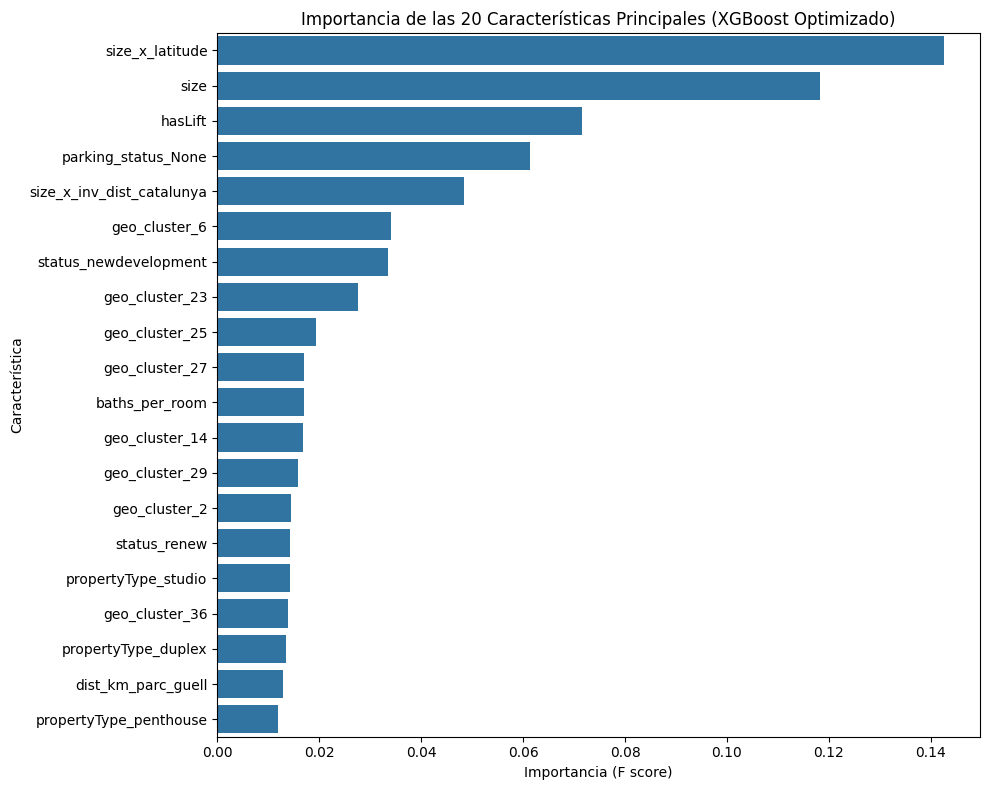

------------------------------


In [90]:
# BLOQUE 19: Analizar Importancia de Características (MEJOR XGBoost)
print("--- BLOQUE 19: Analizar Importancia de Características (MEJOR XGBoost) ---")
# Usamos X_train_scaled porque el modelo se entrenó con datos escalados,
# pero los nombres de columnas los tomamos de X_train (DataFrame original antes de escalar)
if 'best_xgb_model' not in locals() or 'X_train' not in locals():
     print("Error: El mejor modelo XGBoost o X_train (para nombres) no existen.")
else:
    # Obtener importancias del MEJOR modelo XGBoost
    # Usamos X_train.columns para obtener los nombres correctos
    feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("Importancia de las características (Top 20) - Modelo Optimizado:")
    print(feature_importances.head(20))
    # Graficar
    n_features_to_plot = 20
    plt.figure(figsize=(10, 8))
    # Asegurarse de que hay suficientes features para graficar
    num_features = min(n_features_to_plot, len(feature_importances))
    sns.barplot(x=feature_importances.head(num_features), y=feature_importances.head(num_features).index)
    plt.title(f'Importancia de las {num_features} Características Principales (XGBoost Optimizado)')
    plt.xlabel('Importancia (F score)')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()
    print("-" * 30)

--- BLOQUE 20: Agregar Importancia de Características para 'geo_cluster' ---
Importancia total agregada para 'geo_cluster': 0.3711

Importancia de características (con 'geo_cluster' agregado) - Top 20:
geo_cluster (Total)          0.371064
size_x_latitude              0.142514
size                         0.118235
hasLift                      0.071480
parking_status_None          0.061403
size_x_inv_dist_catalunya    0.048470
status_newdevelopment        0.033460
baths_per_room               0.017010
status_renew                 0.014348
propertyType_studio          0.014184
propertyType_duplex          0.013399
dist_km_parc_guell           0.012979
propertyType_penthouse       0.011946
rooms                        0.010896
propertyType_flat            0.010764
dist_km_placa_catalunya      0.009537
floor                        0.008995
dist_km_camp_nou             0.008054
exterior                     0.006634
dist_km_sants_estacio        0.006435
dtype: float64


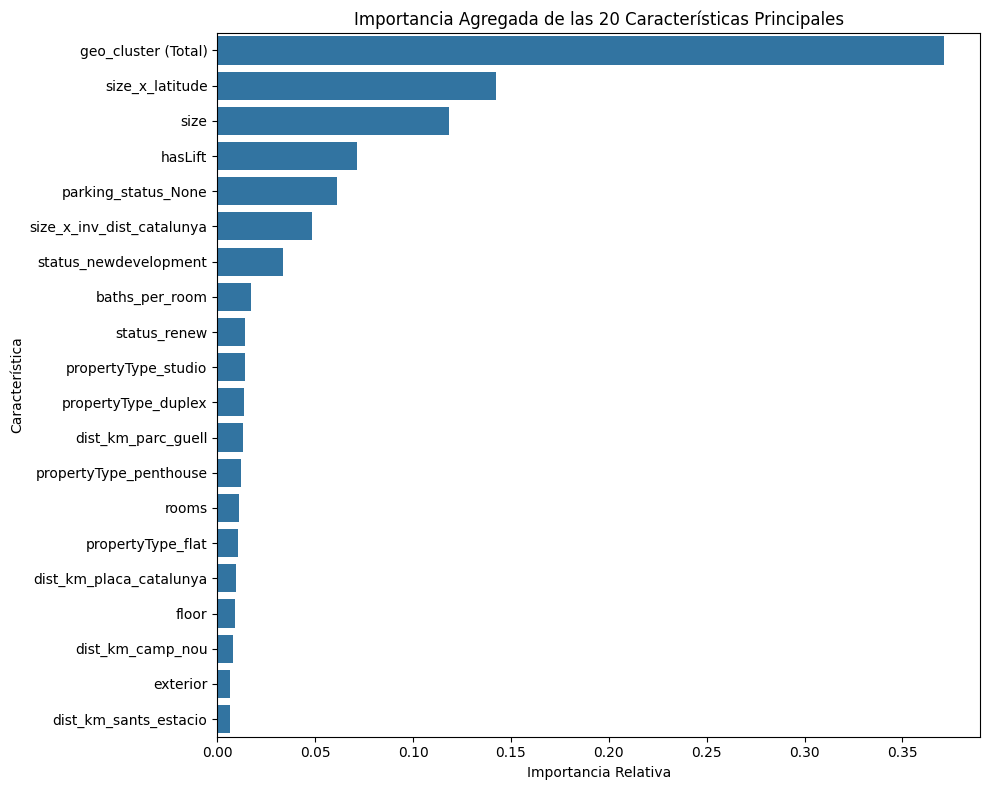

------------------------------


In [92]:
# --- NUEVO BLOQUE ---
# BLOQUE 20: Agregar Importancia de Características para 'geo_cluster'
print("--- BLOQUE 20: Agregar Importancia de Características para 'geo_cluster' ---")

# Asegurarse de que la serie de importancias existe del bloque anterior
if 'feature_importances' not in locals():
     print("Error: La serie 'feature_importances' no existe. Ejecuta el bloque 19 primero.")
else:
    # Identificar todas las columnas que son dummies de geo_cluster
    cluster_dummy_features = [col for col in feature_importances.index if col.startswith('geo_cluster_')]

    if not cluster_dummy_features:
        print("No se encontraron características dummy de 'geo_cluster'. Revisar nombres de columnas.")
        aggregated_importance = feature_importances.copy() # Continuar con la original
    else:
        # Calcular la suma de importancia de todos los dummies de cluster
        total_cluster_importance = feature_importances[cluster_dummy_features].sum()
        print(f"Importancia total agregada para 'geo_cluster': {total_cluster_importance:.4f}")

        # Crear una nueva serie eliminando los dummies individuales
        importance_no_clusters = feature_importances.drop(labels=cluster_dummy_features)

        # Crear un diccionario para la nueva serie agregada
        aggregated_importance_dict = importance_no_clusters.to_dict()
        # Añadir la importancia agregada de los clusters
        aggregated_importance_dict['geo_cluster (Total)'] = total_cluster_importance

        # Convertir de nuevo a Series para ordenar y graficar
        aggregated_importance = pd.Series(aggregated_importance_dict)

        # Ordenar la nueva serie de importancia agregada
        aggregated_importance = aggregated_importance.sort_values(ascending=False)

    # Mostrar la nueva lista de importancia agregada (Top 20)
    print("\nImportancia de características (con 'geo_cluster' agregado) - Top 20:")
    print(aggregated_importance.head(20))

    # Graficar la importancia agregada
    n_features_to_plot_agg = 20
    plt.figure(figsize=(10, 8))
    # Asegurarse de que hay suficientes features para graficar
    features_to_plot = aggregated_importance.head(n_features_to_plot_agg)
    sns.barplot(x=features_to_plot.values, y=features_to_plot.index)
    plt.title(f'Importancia Agregada de las {len(features_to_plot)} Características Principales')
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()
    print("-" * 30)

In [91]:
# --- BLOQUE 20: Exportar el Modelo, Scaler y Columnas ---
print("--- BLOQUE 20: Exportar el Modelo, Scaler y Columnas ---")

import joblib
import os
import pickle # Para guardar la lista de columnas

# Asegurarse de que las variables necesarias existen
if 'best_xgb_model' not in locals():
     print("Error: No se encontró la variable 'best_xgb_model'. No se puede guardar el modelo.")
elif 'scaler' not in locals():
     print("Error: No se encontró la variable 'scaler'. No se puede guardar el escalador.")
elif 'X_train' not in locals():
      print("Error: No se encontró la variable 'X_train' para obtener los nombres de columnas.")
else:
    # Definir la ruta de destino en Google Drive
    export_path = '/content/drive/MyDrive/ModelosIdealista/'

    # Crear el directorio si no existe
    try:
        os.makedirs(export_path, exist_ok=True)
        print(f"Directorio de destino asegurado: {export_path}")
    except OSError as e:
        print(f"Error al crear el directorio {export_path}: {e}")
        export_path = None # Indicar que no se puede guardar

    if export_path:
        # Definir nombres de archivo
        model_filename = os.path.join(export_path, 'xgboost_pisos_barcelona_best_v1.joblib')
        scaler_filename = os.path.join(export_path, 'scaler_pisos_barcelona_v1.joblib')
        columns_filename = os.path.join(export_path, 'model_columns_v1.pkl')

        try:
            # Guardar el modelo XGBoost
            joblib.dump(best_xgb_model, model_filename)
            print(f"Modelo XGBoost guardado exitosamente en: {model_filename}")

            # Guardar el Scaler
            joblib.dump(scaler, scaler_filename)
            print(f"Scaler guardado exitosamente en: {scaler_filename}")

            # Guardar la lista de columnas (importante para predecir con nuevos datos)
            model_columns = X_train.columns.tolist() # Obtener la lista de nombres de columnas
            with open(columns_filename, 'wb') as f:
                pickle.dump(model_columns, f)
            print(f"Lista de columnas del modelo guardada exitosamente en: {columns_filename}")

        except Exception as e:
            print(f"Ocurrió un error al guardar los archivos: {e}")

print("-" * 30)

--- BLOQUE 20: Exportar el Modelo, Scaler y Columnas ---
Directorio de destino asegurado: /content/drive/MyDrive/ModelosIdealista/
Modelo XGBoost guardado exitosamente en: /content/drive/MyDrive/ModelosIdealista/xgboost_pisos_barcelona_best_v1.joblib
Scaler guardado exitosamente en: /content/drive/MyDrive/ModelosIdealista/scaler_pisos_barcelona_v1.joblib
Lista de columnas del modelo guardada exitosamente en: /content/drive/MyDrive/ModelosIdealista/model_columns_v1.pkl
------------------------------
